# DQN vs Double DQN , DQN vs Multistep DQN and DQN vs Dueling Networks DQN

This notebook implements and compares:
- Vanilla DQN
- Double DQN 
- Multi-step DQN
- Dueling Networks DQN


In [1]:
# Install dependencies
!pip install torch torchvision torchaudio
!pip install gymnasium==0.29.1
!pip install minatar==1.0.15
!pip install matplotlib
!pip install pandas

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import numpy as np
import pandas as pd
import random
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import namedtuple
import itertools

## Network Architecture

In [2]:
class DQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):
        """
        Initialize the DQN network.
        
        :param obs_shape: Shape of the observation space
        :param num_actions: Number of actions
        """
        super(DQN, self).__init__()

        self.conv1 = nn.Conv2d(obs_shape[-1], 16, stride=1, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, stride=1, kernel_size=3)
        
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_actions)

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 3, 1, 2)

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        x = torch.flatten(x, 1)

        x = self.relu(self.fc1(x))
        out = self.fc2(x)
        return out



# Dueling networks extention

class DuelingDQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):
      
        super(DuelingDQN, self).__init__()
        self.conv1 = nn.Conv2d(obs_shape[-1], 16, stride=1, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, stride=1, kernel_size=3)
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
       
        # New dueling heads
        self.value_fc = nn.Linear(128, 1)          # V(s), value stream
        self.advantage_fc = nn.Linear(128, num_actions)  # A(s, a) ,  advantage stream
        
        self.relu = nn.ReLU()
       


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        x = x.permute(0, 3, 1, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        x = torch.flatten(x, 1) # flatten the intermediate result such that it can serve as input for the first linear layer

        # Final layer consists of 128 "rectifier" units meaning a ReLU activation
        x = self.relu(self.fc1(x))
        # Dueling streams
        value = self.value_fc(x)              # shape: (batch, 1)
        advantage = self.advantage_fc(x)      # shape: (batch, num_actions)
        
        # aggregate  value + advantage to get Q(s,a) 
        q_values = value + advantage - advantage.mean(dim=1, keepdim=True)
        
        return q_values


## Epsilon-Greedy Policy

In [3]:
def make_epsilon_greedy_policy(Q: nn.Module, num_actions: int):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.

    :param Q: The DQN network.
    :param num_actions: Number of actions in the environment.

    :returns: A function that takes the observation as an argument and returns the greedy action.
    """
    def policy_fn(obs: torch.Tensor, epsilon: float = 0.0):
        if np.random.uniform() < epsilon:
            return np.random.randint(0, num_actions)
        
        return Q(obs).argmax().detach().numpy()

    return policy_fn

## Epsilon Decay Schedule

In [4]:
def linear_epsilon_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int) -> float:
    """
    Linear decay of epsilon.

    :param eps_start: The initial epsilon value.
    :param eps_end: The final epsilon value.
    :param current_timestep: The current timestep.
    :param duration: The duration of the schedule (in timesteps).

    :returns: The current epsilon.
    """
    ratio = min(1.0, current_timestep / duration)
    return (eps_start - eps_end) * (1 - ratio) + eps_end

## Replay Buffer

In [5]:
class ReplayBuffer:
    def __init__(self, max_size: int):
        """
        Create the replay buffer.

        :param max_size: Maximum number of transitions in the buffer.
        """
        self.data = []
        self.max_size = max_size
        self.position = 0

    def __len__(self) -> int:
        return len(self.data)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor, n_steps: torch.Tensor):
        """
        Adds a new transition to the buffer.
        """
        if len(self.data) < self.max_size:
            self.data.append((obs, action, reward, next_obs, terminated, n_steps))
        else:
            self.data[self.position] = (obs, action, reward, next_obs, terminated, n_steps)
        self.position = (self.position + 1) % self.max_size

    def sample(self, batch_size: int) -> torch.Tensor:
        """
        Sample a batch of transitions uniformly and with replacement.
        """
        return [torch.stack(b) for b in zip(*random.choices(self.data, k=batch_size))]

## n-step Buffer

In [6]:
class nStepBuffer:
    def __init__(self, n: int, gamma: float):
        """
        Create the n-step buffer.

        :param n: The number of steps to look ahead.
        """
        self.data = []
        self.n = n
        self.gamma = gamma
        self.position = 0
        self.first_n = 0

    def reset(self):
        self.data = []
        self.position = 0
        self.first_n = 0  # Should be the only attribute thats not reset anyway
        
    def update(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        """
        Adds a new transition to the buffer.
        """
        if self.first_n < self.n:
            self.data.append((obs, action, reward, next_obs, terminated))
        else:
            self.data[self.position] = (obs, action, reward, next_obs, terminated)
        self.position = (self.position + 1) % (self.n if (self.first_n < self.n and not terminated) else len(self.data))

        if self.first_n < self.n and not terminated:
            self.first_n += 1
            return None, None, None, None, None, None
        else:
            R = torch.tensor(0.0)
            for k in range(len(self.data)):
                R = R + (self.gamma ** k) * self.data[(self.position + k) % len(self.data)][2]
            
            obs_t = self.data[self.position][0]
            action_t = self.data[self.position][1]
            next_obs_t = self.data[(self.position - 1) % len(self.data)][3]
            terminated_t = self.data[(self.position - 1) % len(self.data)][4]
            n_transitions = len(self.data)

            if terminated:
                if self.first_n < self.n:
                    self.first_n = self.n
                del self.data[(self.position - 1) % len(self.data)]
                self.position = (self.position - 1) % len(self.data) if self.position > 0 else 0

            return obs_t, action_t, R, next_obs_t, terminated_t, n_transitions

## Update Functions

### Vanilla DQN Update

In [7]:
def update_dqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
        n_steps: torch.Tensor,
    ):
    """
    Update the vanilla DQN.
    Uses the target network to both select and evaluate actions.
    Supports n-step returns via the n_steps input.
    """
    optimizer.zero_grad()

    # Vanilla DQN: Use target network to select AND evaluate
    with torch.no_grad():
        discount = torch.pow(torch.tensor(gamma, device=rew.device), n_steps.float())
        td_target = rew + discount * q_target(next_obs).max(dim=1)[0] * (1 - tm.float())

    # Calculate loss
    loss = F.mse_loss(q(obs).gather(1, act.unsqueeze(1)), td_target.unsqueeze(1))

    # Backpropagate
    loss.backward()
    optimizer.step()
    
    return loss.item()

### Double DQN Update

The key innovation: Use the online network to **select** the best action, but use the target network to **evaluate** it.

In [8]:
def update_double_dqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
        n_steps: torch.Tensor,
    ):
    """
    Update the DQN network using Double DQN.
    Uses the online network to select actions, but target network to evaluate them.
    """
    optimizer.zero_grad()

    # Double DQN: Use online network to SELECT action, target network to EVALUATE
    with torch.no_grad():
        # Select best action using online network
        best_actions = q(next_obs).argmax(dim=1)
        # Evaluate selected action using target network
        next_q_values = q_target(next_obs).gather(1, best_actions.unsqueeze(1)).squeeze(1)
        discount = torch.pow(torch.tensor(gamma, device=rew.device), n_steps.float())
        td_target = rew + discount * next_q_values * (1 - tm.float())

    # Calculate loss
    loss = F.mse_loss(q(obs).gather(1, act.unsqueeze(1)), td_target.unsqueeze(1))

    # Backpropagate
    loss.backward()
    optimizer.step()
    
    return loss.item()

## Agent Classes

In [9]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards", "losses"])

class DQNAgent:
    def __init__(self,
            env,
            net_type="vanilla",
            gamma=0.99,
            lr=0.001, 
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
            n_steps=1,
            use_double_dqn=False,
        ):
        """
        Initialize the DQN agent.
        
        :param env: The environment.
        :param gamma: The discount factor.
        :param lr: The learning rate.
        :param batch_size: Mini batch size.
        :param eps_start: The initial epsilon value.
        :param eps_end: The final epsilon value.
        :param schedule_duration: The duration of the schedule (in timesteps).
        :param update_freq: How often to update the Q target.
        :param max_size: Maximum number of transitions in the buffer.
        :param use_double_dqn: If True, use Double DQN update rule
        """
        self.env = env
        self.net_type = net_type 
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq
        self.n_steps = n_steps
        self.n_transitions = 1
        self.use_double_dqn = use_double_dqn

        self.buffer = ReplayBuffer(maxlen)
        self.nstep_buffer = nStepBuffer(n=n_steps, gamma=gamma)

        # due to different network architecture 
        self.q = self.make_network(
            net_type,
            env.observation_space.shape,
            env.action_space.n
        )
        
        self.q_target = self.make_network(
            net_type,
            env.observation_space.shape,
            env.action_space.n
        )

        
        self.q_target.load_state_dict(self.q.state_dict())
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)
        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)

    # deciding which network to choose 

    def make_network(self, net_type, obs_shape, n_actions):
        if net_type == "vanilla":
            return DQN(obs_shape, n_actions)
        elif net_type == "dueling":
            return DuelingDQN(obs_shape, n_actions)
        else:
            raise ValueError(f"Unknown net_type: {net_type}")

    def train(self, num_episodes: int) -> EpisodeStats:
        """
        Train the DQN agent.

        :param num_episodes: Number of episodes to train.
        :returns: The episode statistics.
        """
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
            losses=[],
        )
        current_timestep = 0
        epsilon = self.eps_start
        
        #agent_type = "Double DQN" if self.use_double_dqn else "Vanilla DQN"
        
        for i_episode in range(num_episodes):
            if (i_episode + 1) % 100 == 0:
                print(f'Episode {i_episode + 1}/{num_episodes}  '
                      f'Time Step: {current_timestep}  Epsilon: {epsilon:.3f}  '
                      f'Avg Reward: {np.mean(stats.episode_rewards[max(0, i_episode-99):i_episode+1]):.2f}')

            self.nstep_buffer.reset()
            obs, _ = self.env.reset()
            
            for episode_time in itertools.count():
                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)

                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                stats.episode_lengths[i_episode] += 1
                stats.episode_rewards[i_episode] += reward
                
                # Store in n-step buffer and get "ready" transition from there
                if self.n_steps > 1:
                    obs_t, action_t, reward_t, next_obs, terminated, n_transitions = self.nstep_buffer.update(obs, action, reward, next_obs, terminated)
                else:
                    obs_t = obs
                    action_t = action
                    reward_t = reward
                    n_transitions = self.n_transitions

                # Skip if n-step buffer is not ready yet
                if obs_t is not None:

                    self.buffer.store(
                        torch.as_tensor(obs_t, dtype=torch.float32),
                        torch.as_tensor(action_t),
                        torch.as_tensor(reward_t, dtype=torch.float32),
                        torch.as_tensor(next_obs, dtype=torch.float32),
                        torch.as_tensor(terminated),
                        torch.as_tensor(n_transitions)
                    )

                    if len(self.buffer) >= self.batch_size:
                        obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch, n_steps_batch = self.buffer.sample(self.batch_size)
                        
                        # Choose update function based on algorithm
                        if self.use_double_dqn:
                            loss = update_double_dqn(
                                self.q, self.q_target, self.optimizer, self.gamma,
                                obs_batch.float(), act_batch, rew_batch.float(),
                                next_obs_batch.float(), tm_batch, n_steps_batch
                            )
                        else:
                            loss = update_dqn(
                                self.q, self.q_target, self.optimizer, self.gamma,
                                obs_batch.float(), act_batch, rew_batch.float(),
                                next_obs_batch.float(), tm_batch, n_steps_batch
                            )
                        
                        stats.losses.append(loss)

                    if current_timestep % self.update_freq == 0:
                        self.q_target.load_state_dict(self.q.state_dict())
                        
                    current_timestep += 1

                    if terminated or truncated or episode_time >= 500:
                        # Handle pending n-step transitions
                        while n_transitions > 1:
                            obs_t, action_t, reward_t, next_obs, terminated, n_transitions = self.nstep_buffer.update(obs, action, reward, next_obs, terminated)

                            self.buffer.store(
                                torch.as_tensor(obs_t, dtype=torch.float32),
                                torch.as_tensor(action_t),
                                torch.as_tensor(reward_t, dtype=torch.float32),
                                torch.as_tensor(next_obs, dtype=torch.float32),
                                torch.as_tensor(terminated),
                                torch.as_tensor(n_transitions)
                            )
                        break
                        
                    obs = next_obs
                
        return stats

## Training



In [10]:
# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Hyperparameters
LR = 0.00025
BATCH_SIZE = 32
REPLAY_BUFFER_SIZE = 100_000
UPDATE_FREQ = 1000
EPS_START = 1.0
EPS_END = 0.01
SCHEDULE_DURATION = 100_000
NUM_EPISODES = 3_000
DISCOUNT_FACTOR = 0.99

# Create environment
env = gym.make('MinAtar/Breakout-v1', render_mode="rgb_array")

print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

Training on MinAtar/Breakout-v1
Observation space: Box(False, True, (10, 10, 4), bool)
Action space: Discrete(3)



In [11]:
# Train Vanilla DQN

print("TRAINING VANILLA DQN")

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

vanilla_agent = DQNAgent(
    env, 
    gamma=DISCOUNT_FACTOR,
    lr=LR, 
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
    use_double_dqn=False,
)
vanilla_stats = vanilla_agent.train(NUM_EPISODES)

TRAINING VANILLA DQN
Episode 100/3000  Time Step: 920  Epsilon: 0.991  Avg Reward: 0.32
Episode 200/3000  Time Step: 1874  Epsilon: 0.981  Avg Reward: 0.35
Episode 300/3000  Time Step: 2826  Epsilon: 0.972  Avg Reward: 0.34
Episode 400/3000  Time Step: 3872  Epsilon: 0.962  Avg Reward: 0.43
Episode 500/3000  Time Step: 4916  Epsilon: 0.951  Avg Reward: 0.43
Episode 600/3000  Time Step: 5942  Epsilon: 0.941  Avg Reward: 0.42
Episode 700/3000  Time Step: 7006  Epsilon: 0.931  Avg Reward: 0.45
Episode 800/3000  Time Step: 8138  Epsilon: 0.919  Avg Reward: 0.51
Episode 900/3000  Time Step: 9156  Epsilon: 0.909  Avg Reward: 0.41
Episode 1000/3000  Time Step: 10194  Epsilon: 0.899  Avg Reward: 0.42
Episode 1100/3000  Time Step: 11204  Epsilon: 0.889  Avg Reward: 0.40
Episode 1200/3000  Time Step: 12218  Epsilon: 0.879  Avg Reward: 0.41
Episode 1300/3000  Time Step: 13390  Epsilon: 0.867  Avg Reward: 0.56
Episode 1400/3000  Time Step: 14638  Epsilon: 0.855  Avg Reward: 0.62
Episode 1500/3000 

In [14]:
# Train multi-step DQN
print("TRAINING MULTISTEP DQN")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

multistep_agent = DQNAgent(
    env, 
    gamma=0.99,
    lr=0.00025, 
    batch_size=32,
    eps_start=1.0, 
    eps_end=0.01,
    schedule_duration=100_000,  
    update_freq=1000,
    maxlen=100_000,
    n_steps=3,
    use_double_dqn=False
)
multistep_stats = multistep_agent.train(3000)

TRAINING MULTISTEP DQN
Episode 100/3000  Time Step: 747  Epsilon: 0.993  Avg Reward: 0.44
Episode 200/3000  Time Step: 1397  Epsilon: 0.986  Avg Reward: 0.33
Episode 300/3000  Time Step: 2135  Epsilon: 0.979  Avg Reward: 0.41
Episode 400/3000  Time Step: 2905  Epsilon: 0.971  Avg Reward: 0.45
Episode 500/3000  Time Step: 3581  Epsilon: 0.965  Avg Reward: 0.37
Episode 600/3000  Time Step: 4319  Epsilon: 0.957  Avg Reward: 0.43
Episode 700/3000  Time Step: 4993  Epsilon: 0.951  Avg Reward: 0.37
Episode 800/3000  Time Step: 5693  Epsilon: 0.944  Avg Reward: 0.38
Episode 900/3000  Time Step: 6433  Epsilon: 0.936  Avg Reward: 0.43
Episode 1000/3000  Time Step: 7289  Epsilon: 0.928  Avg Reward: 0.54
Episode 1100/3000  Time Step: 8047  Epsilon: 0.920  Avg Reward: 0.44
Episode 1200/3000  Time Step: 8975  Epsilon: 0.911  Avg Reward: 0.61
Episode 1300/3000  Time Step: 9897  Epsilon: 0.902  Avg Reward: 0.61
Episode 1400/3000  Time Step: 10709  Epsilon: 0.894  Avg Reward: 0.50
Episode 1500/3000  T

In [13]:
# Train Double DQN

print("TRAINING DOUBLE DQN")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

double_agent = DQNAgent(
    env, 
    gamma=DISCOUNT_FACTOR,
    lr=LR, 
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
    use_double_dqn=True,
)
double_stats = double_agent.train(NUM_EPISODES)

TRAINING DOUBLE DQN
Episode 100/3000  Time Step: 976  Epsilon: 0.990  Avg Reward: 0.38
Episode 200/3000  Time Step: 2004  Epsilon: 0.980  Avg Reward: 0.42
Episode 300/3000  Time Step: 3014  Epsilon: 0.970  Avg Reward: 0.40
Episode 400/3000  Time Step: 4050  Epsilon: 0.960  Avg Reward: 0.43
Episode 500/3000  Time Step: 5216  Epsilon: 0.948  Avg Reward: 0.55
Episode 600/3000  Time Step: 6060  Epsilon: 0.940  Avg Reward: 0.24
Episode 700/3000  Time Step: 7158  Epsilon: 0.929  Avg Reward: 0.48
Episode 800/3000  Time Step: 8240  Epsilon: 0.918  Avg Reward: 0.47
Episode 900/3000  Time Step: 9216  Epsilon: 0.909  Avg Reward: 0.37
Episode 1000/3000  Time Step: 10218  Epsilon: 0.899  Avg Reward: 0.37
Episode 1100/3000  Time Step: 11344  Epsilon: 0.888  Avg Reward: 0.51
Episode 1200/3000  Time Step: 12420  Epsilon: 0.877  Avg Reward: 0.44
Episode 1300/3000  Time Step: 13594  Epsilon: 0.865  Avg Reward: 0.56
Episode 1400/3000  Time Step: 14698  Epsilon: 0.854  Avg Reward: 0.49
Episode 1500/3000  

In [16]:
# Train Dueling extension 
print("TRAINING Dueling extension ")

# Choose  environment
env = gym.make('MinAtar/Breakout-v1', render_mode="rgb_array")

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

dueling_agent = DQNAgent(
    env, 
    net_type="dueling",
    gamma=DISCOUNT_FACTOR,
    lr=LR, 
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
    use_double_dqn=False,
)
dueling_stats = dueling_agent.train(NUM_EPISODES)

# saving stats to resuse for analysis 

np.savez("results/dueling_stats.npz",
         episode_rewards=dueling_stats.episode_rewards,
         episode_lengths=dueling_stats.episode_lengths,
         losses=dueling_stats.losses)

print("Dueling stats saved to restuls/dueling_stats.npz")

TRAINING Dueling extension 
Episode 100/3000  Time Step: 1128  Epsilon: 0.989  Avg Reward: 0.52
Episode 200/3000  Time Step: 2114  Epsilon: 0.979  Avg Reward: 0.37
Episode 300/3000  Time Step: 3110  Epsilon: 0.969  Avg Reward: 0.39
Episode 400/3000  Time Step: 4128  Epsilon: 0.959  Avg Reward: 0.41
Episode 500/3000  Time Step: 5136  Epsilon: 0.949  Avg Reward: 0.40
Episode 600/3000  Time Step: 6176  Epsilon: 0.939  Avg Reward: 0.41
Episode 700/3000  Time Step: 7278  Epsilon: 0.928  Avg Reward: 0.49
Episode 800/3000  Time Step: 8494  Epsilon: 0.916  Avg Reward: 0.60
Episode 900/3000  Time Step: 9708  Epsilon: 0.904  Avg Reward: 0.59
Episode 1000/3000  Time Step: 10776  Epsilon: 0.893  Avg Reward: 0.45
Episode 1100/3000  Time Step: 11740  Epsilon: 0.884  Avg Reward: 0.35
Episode 1200/3000  Time Step: 13016  Epsilon: 0.871  Avg Reward: 0.64
Episode 1300/3000  Time Step: 14312  Epsilon: 0.858  Avg Reward: 0.68
Episode 1400/3000  Time Step: 15610  Epsilon: 0.845  Avg Reward: 0.67
Episode 15

In [36]:
# Train all three extensions together 
print("\n" + "="*70)
print("TRAINING Double + Multistep + Dueling extension together")
print("="*70 + "\n")



# Choose  environment
env = gym.make('MinAtar/Breakout-v1', render_mode="rgb_array")

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

merged_agent = DQNAgent(
    env, 
    net_type="dueling",
    gamma=DISCOUNT_FACTOR,
    lr=LR, 
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
    n_steps=3,
    use_double_dqn=True,
)
merged_stats = merged_agent.train(NUM_EPISODES)

# saving stats to resuse for analysis 

np.savez("results/merged_stats.npz",
         episode_rewards=merged_stats.episode_rewards,
         episode_lengths=merged_stats.episode_lengths,
         losses=merged_stats.losses)

print("overall stats saved to results/merged_stats.npz")


TRAINING Double + Multistep + Dueling extension together

Episode 100/3000  Time Step: 601  Epsilon: 0.994  Avg Reward: 0.30
Episode 200/3000  Time Step: 1227  Epsilon: 0.988  Avg Reward: 0.32
Episode 300/3000  Time Step: 1823  Epsilon: 0.982  Avg Reward: 0.29
Episode 400/3000  Time Step: 2493  Epsilon: 0.975  Avg Reward: 0.36
Episode 500/3000  Time Step: 3169  Epsilon: 0.969  Avg Reward: 0.36
Episode 600/3000  Time Step: 3867  Epsilon: 0.962  Avg Reward: 0.38
Episode 700/3000  Time Step: 4543  Epsilon: 0.955  Avg Reward: 0.37
Episode 800/3000  Time Step: 5307  Epsilon: 0.947  Avg Reward: 0.45
Episode 900/3000  Time Step: 6187  Epsilon: 0.939  Avg Reward: 0.56
Episode 1000/3000  Time Step: 6875  Epsilon: 0.932  Avg Reward: 0.38
Episode 1100/3000  Time Step: 7643  Epsilon: 0.924  Avg Reward: 0.46
Episode 1200/3000  Time Step: 8369  Epsilon: 0.917  Avg Reward: 0.41
Episode 1300/3000  Time Step: 9419  Epsilon: 0.907  Avg Reward: 0.71
Episode 1400/3000  Time Step: 10105  Epsilon: 0.900  A

## Results Comparison


In [43]:
# Display GIF 

from IPython.display import display, HTML

def display_gifs_side_by_side(path1, label1, path2, label2, path3, label3, path4, label4, path5, label5, width=250):
    """Display  GIFs side by side with labels below each."""
    html_code = f"""
    <div style="display:flex; gap:20px; align-items:flex-start;">
        <div style="text-align:center;">
            <img src="{path1}" width="{width}"><br>
            <b>{label1}</b>
        </div>
        <div style="text-align:center;">
            <img src="{path2}" width="{width}"><br>
            <b>{label2}</b>
        </div>
        <div style="text-align:center;">
            <img src="{path3}" width="{width}"><br>
            <b>{label3}</b>
        </div>
        <div style="text-align:center;">
            <img src="{path4}" width="{width}"><br>
            <b>{label4}</b>
        </div>
        <div style="text-align:center;">
            <img src="{path5}" width="{width}"><br>
            <b>{label5}</b>
        </div>
    </div>
    """
    display(HTML(html_code))


display_gifs_side_by_side("results/Fvanilla_dqn_trained.gif","Vanilla DQN", "results/Fdouble_dqn_trained.gif","Double DQN", 
                          "results/Fmultistep_dqn_trained.gif" , "MultiStep DQN", "results/Fdueling_dqn_trained.gif","Dueling DQN",
                          "results/Fmerged_dqn_trained.gif", "ALl three extentions merged", width=250)


# Evaluations and plot functions 

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple


# EVALUATION: Test Trained Agents

def evaluate_agent(agent, env, num_episodes=100, seed=42):
    """
    Evaluate a trained agent over multiple episodes.
    Returns: list of episode rewards
    """
    policy = make_epsilon_greedy_policy(agent.q, num_actions=env.action_space.n)
    rewards = []
    
    for i in range(num_episodes):
        obs, _ = env.reset(seed=seed + i)  # Reproducible episodes
        total_reward = 0
        
        for step in range(1000):  # Max steps per episode
            # Greedy policy (no exploration during evaluation)
            action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0), epsilon=0.0)
            obs, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            
            if terminated or truncated:
                break   
        rewards.append(total_reward)
    return rewards

# PLOTTING FUNCTIONS 

def smooth_data(data: np.ndarray, window: int) -> pd.Series:
    # smoothen data using rolling mean
    return pd.Series(data).rolling(window, min_periods=window).mean()


def plot_episode_rewards(ax: plt.Axes, agents_stats: Dict[str, any], smoothing_window: int = 20):
    # Plot smoothed episode rewards for all extensions

    
    for i, (name, stats) in enumerate(agents_stats.items()):
        smoothed = smooth_data(stats.episode_rewards, smoothing_window)
        ax.plot(smoothed, label=name, linewidth=2, alpha=0.9)
    
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Episode Reward (Smoothed)', fontsize=12)
    ax.set_title(f'Episode Rewards Over Time (smoothed over {smoothing_window} episodes)', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

def plot_moving_average_rewards(ax: plt.Axes, agents_stats: Dict[str, any], window: int = 100):

    # Plot moving average of episode rewards.
    for i, (name, stats) in enumerate(agents_stats.items()):
        cumulative = pd.Series(stats.episode_rewards).rolling(window, min_periods=1).mean()
        ax.plot(cumulative, label=name, linewidth=2, alpha=0.9)
    
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel(f'Average Reward (Last {window} episodes)', fontsize=12)
    ax.set_title('Moving Average of Episode Rewards', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)


def create_comparison_plot(
    agents_stats: Dict[str, any],
    title: str = "DQN Variants Comparison",
    smoothing_window: int = 50,
    loss_smoothing: int = 100,
    moving_avg_window: int = 100,
    save_path: str = None,
    figsize: Tuple[int, int] = (15, 10)
):
    '''
    Comparison plot for multiple extensions
    
    Example usage:
        agents = {
            "Vanilla DQN": vanilla_stats,
            "Double DQN": double_stats,
            "Dueling DQN": dueling_stats
        }
        create_comparison_plot(agents, title="DQN Extensions Comparison")
    '''

    # Create figure and subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # Plot 1: Episode Rewards
    plot_episode_rewards(axes[0], agents_stats, smoothing_window)
    
    # Plot 2: Moving Average Rewards
    plot_moving_average_rewards(axes[1], agents_stats, moving_avg_window)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()


def print_performance_summary(agents_stats: Dict[str, any], test_results: Dict[str, List[float]] = None, last_n_episodes: int = 100):
    # Print a comprehensive performance summary table.

    print("PERFORMANCE SUMMARY")

    # Training Performance
    print(f"\nTraining Performance (Last {last_n_episodes} Episodes):")
    print(f"{'Agent':<30} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
    for name, stats in agents_stats.items():
        last_rewards = stats.episode_rewards[-last_n_episodes:]
        print(f"{name:<30} {np.mean(last_rewards):>10.2f} {np.std(last_rewards):>10.2f} "
              f"{np.min(last_rewards):>10.2f} {np.max(last_rewards):>10.2f}")
    
    # Test Performance 
    if test_results:
        print(f"\n\nTest Performance:")
        print(f"{'Agent':<30} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
        baseline_mean = None
        for name, rewards in test_results.items():
            mean_reward = np.mean(rewards)
            if baseline_mean is None:
                baseline_mean = mean_reward
            
            improvement = ((mean_reward - baseline_mean) / baseline_mean * 100) if baseline_mean > 0 else 0
            
            print(f"{name:<30} {mean_reward:>10.2f} {np.std(rewards):>10.2f} "
                  f"{np.min(rewards):>10.2f} {np.max(rewards):>10.2f}", end="")
            
            if name != list(test_results.keys())[0]: 
                print(f"  ({improvement:+.1f}%)", end="")
            print()


# Final PLots 

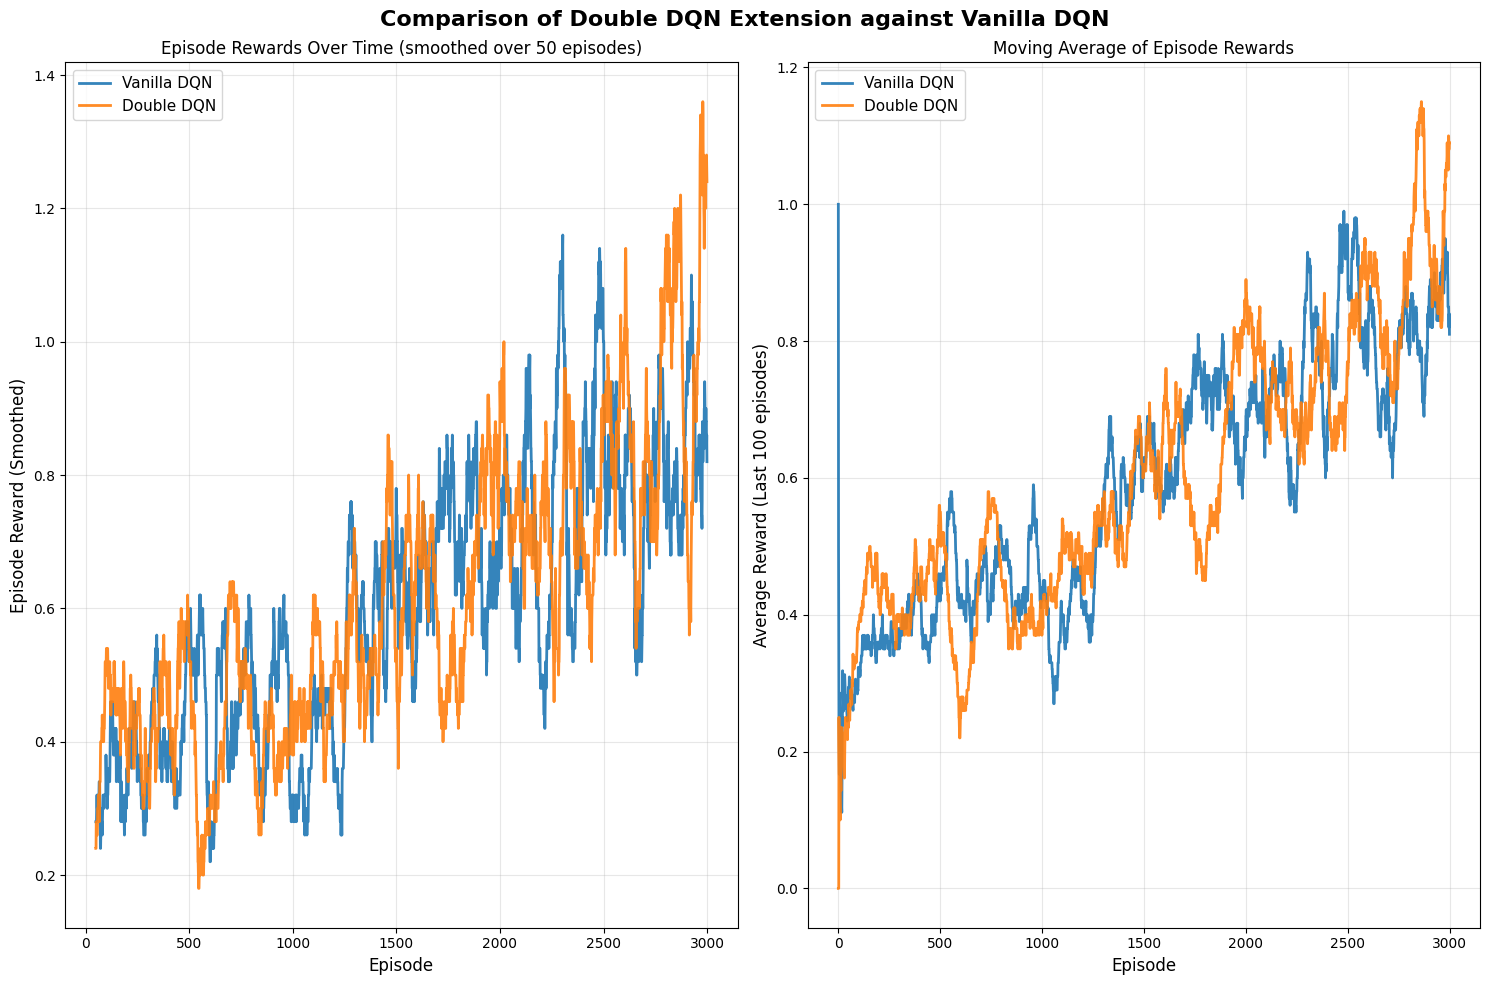

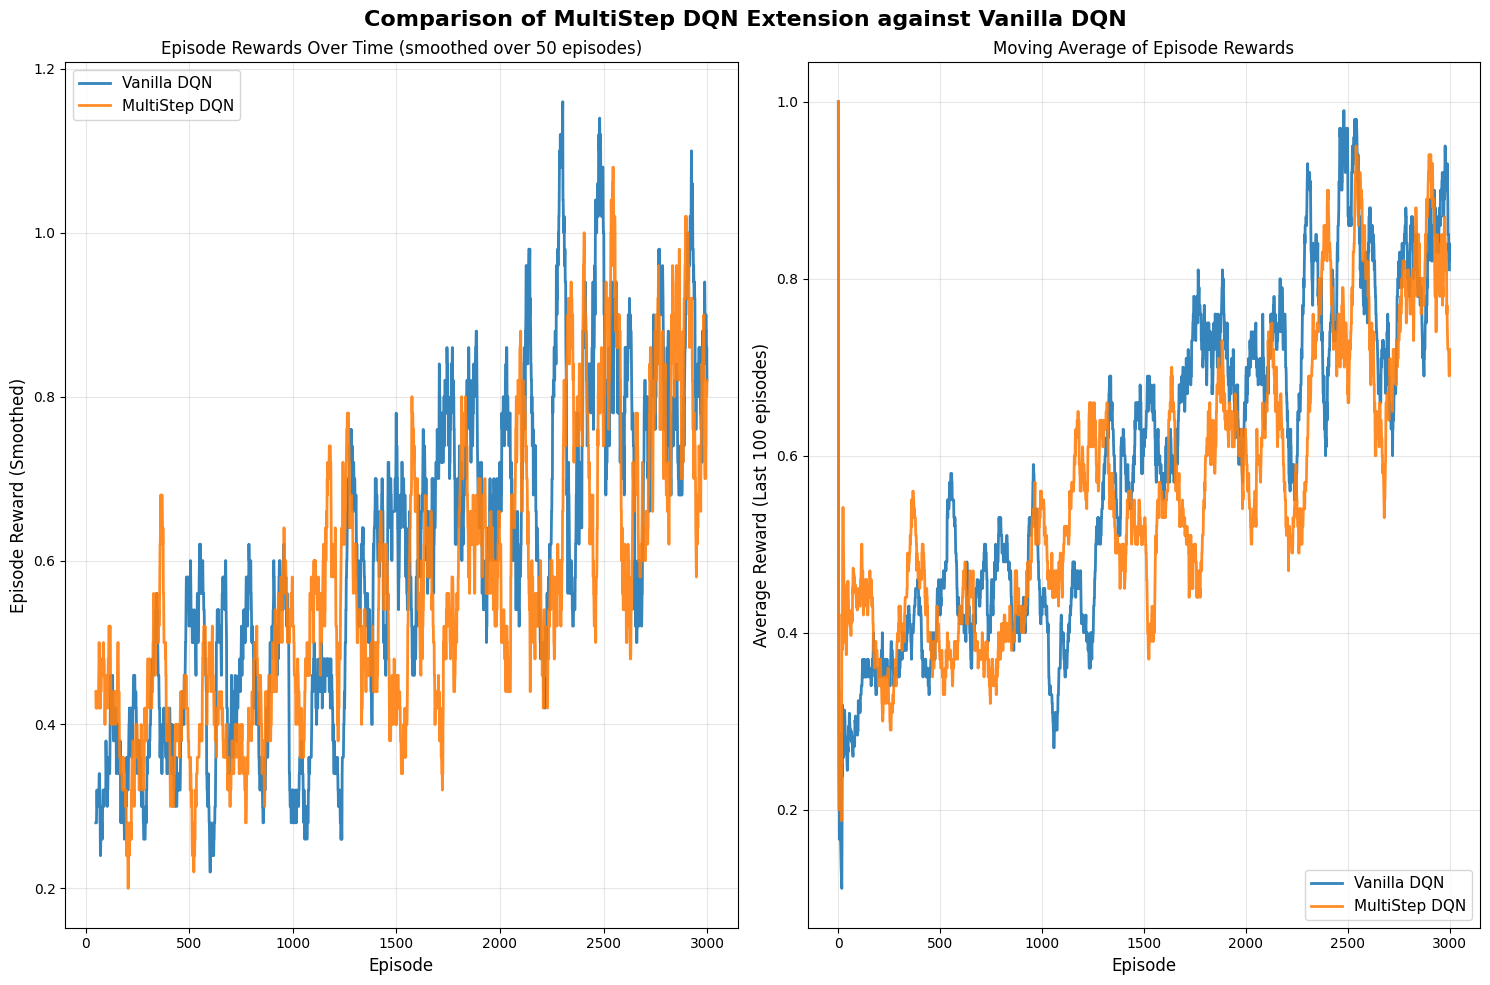

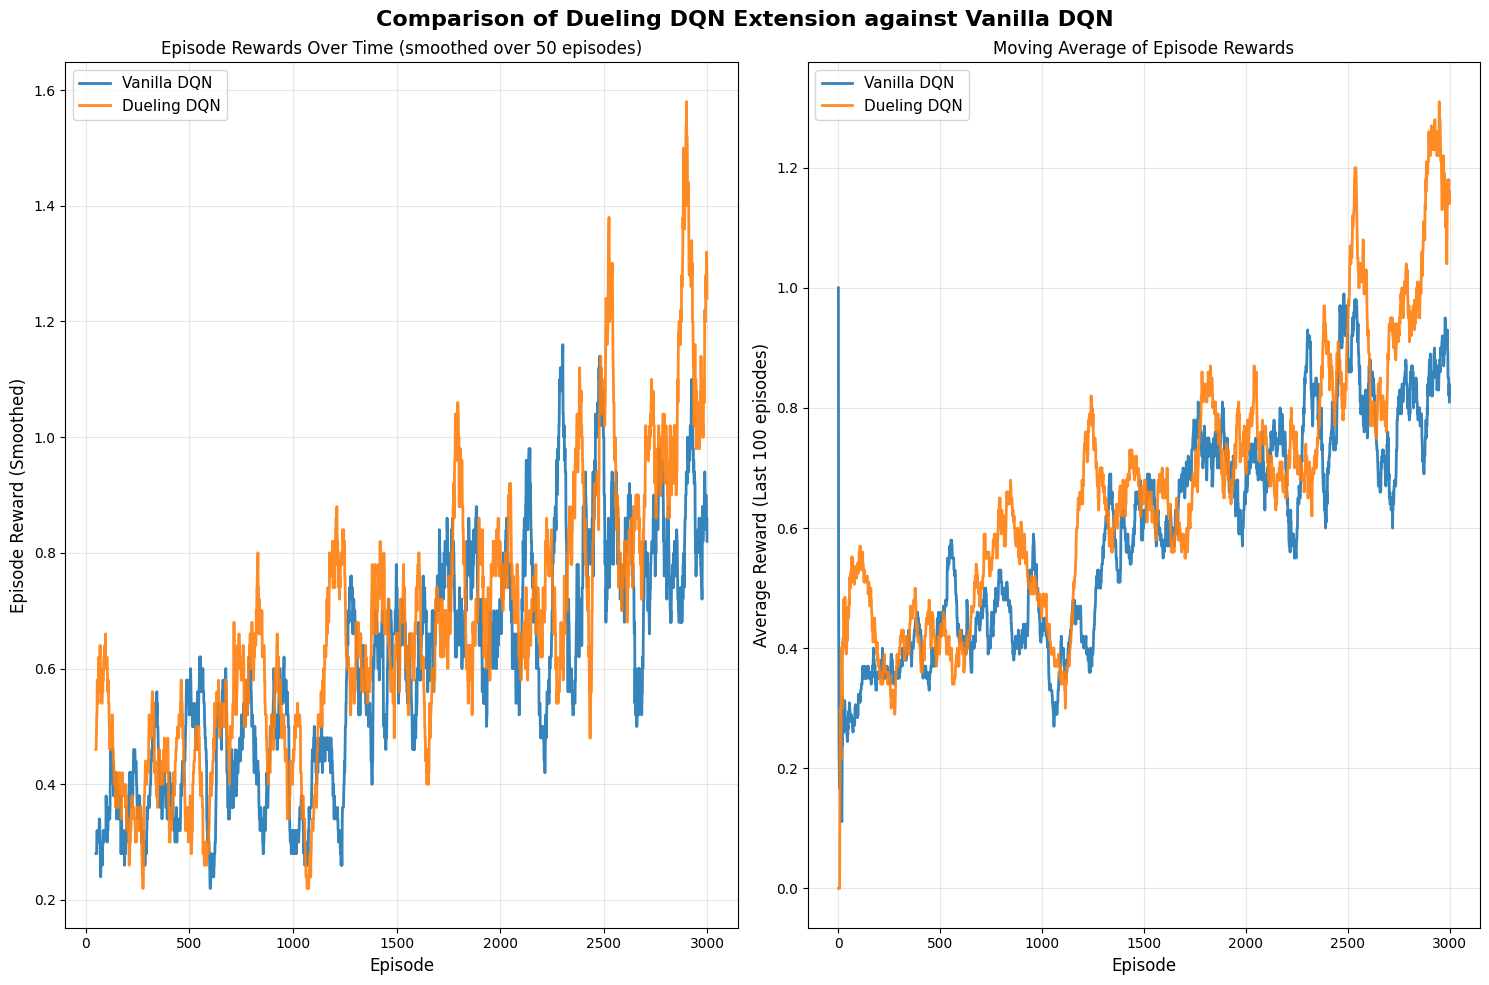

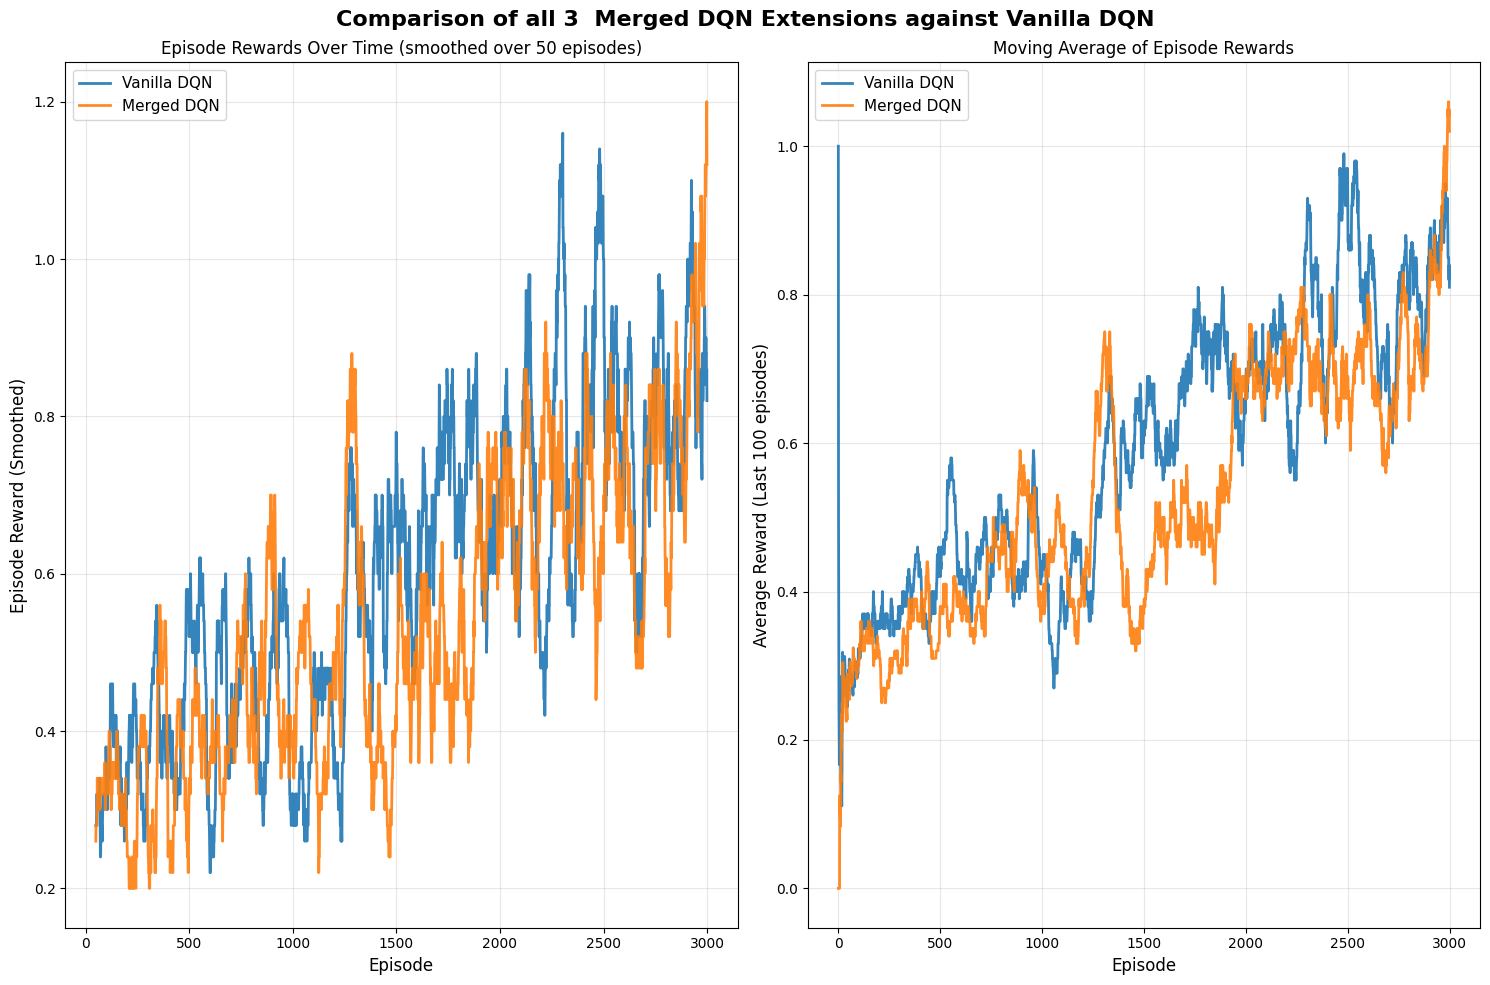

In [76]:
# After training your extensions


# comparing vanilla and double dqn
agents_stats = {
    "Vanilla DQN": vanilla_stats,
    "Double DQN": double_stats,
   
}
# creates both the plots and saves to file
create_comparison_plot(
    agents_stats,
    title="Comparison of Double DQN Extension against Vanilla DQN",
    save_path="results/double_VS_vanilla_comparison.png"
)

# comparing vanilla and multistep dqn
agents_stats = {
    "Vanilla DQN": vanilla_stats,
    "MultiStep DQN": multistep_stats,
   
}
# creates both the plots and saves to file
create_comparison_plot(
    agents_stats,
    title="Comparison of MultiStep DQN Extension against Vanilla DQN",
    save_path="results/multistep_VS_vanilla_comparison.png"
)

# comparing vanilla and dueling  dqn
agents_stats = {
    "Vanilla DQN": vanilla_stats,
    "Dueling DQN": dueling_stats,
   
}
# creates both the plots and saves to file
create_comparison_plot(
    agents_stats,
    title="Comparison of Dueling DQN Extension against Vanilla DQN",
    save_path="results/dueling_VS_vanilla_comparison.png"
)

# comparing vanilla and all three exntentions merged 
agents_stats = {
    "Vanilla DQN": vanilla_stats,
    "Merged DQN": merged_stats,
   
}
# creates both the plots and saves to file
create_comparison_plot(
    agents_stats,
    title="Comparison of all 3  Merged DQN Extensions against Vanilla DQN",
    save_path="results/merged_VS_vanilla_comparison.png"
)



In [45]:
# Evaluate the extensions
vanilla_test_rewards = evaluate_agent(vanilla_agent, env, 100, SEED)
double_test_rewards = evaluate_agent(double_agent, env, 100, SEED)
multistep_test_rewards = evaluate_agent(multistep_agent, env, 100, SEED)
dueling_test_rewards = evaluate_agent(dueling_agent, env, 100, SEED)
merged_test_rewards = evaluate_agent(merged_agent, env, 100, SEED)

test_results = {
    "Vanilla DQN": vanilla_test_rewards,
    "Double DQN": double_test_rewards,
    "Multi-step DQN": multistep_test_rewards,
    "Dueling DQN": dueling_test_rewards,
    "Merged DQN" : merged_test_rewards,
}

print_performance_summary(agents_stats, test_results)

PERFORMANCE SUMMARY

Training Performance (Last 100 Episodes):
Agent                                Mean        Std        Min        Max
Vanilla DQN                          0.81       1.05       0.00       6.00
Double DQN                           1.09       1.33       0.00       6.00
Multi-step DQN                       0.72       0.97       0.00       4.00
Dueling DQN                          1.16       1.26       0.00       6.00
Merged                               1.02       1.09       0.00       5.00


Test Performance:
Agent                                Mean        Std        Min        Max
Vanilla DQN                          3.06       1.52       0.00       6.00
Double DQN                           5.43       1.56       0.00       9.00  (+77.5%)
Multi-step DQN                       3.70       0.92       2.00       7.00  (+20.9%)
Dueling DQN                          4.70       1.62       2.00       7.00  (+53.6%)
Merged DQN                           4.27       1.67       0.0

From the above table we can conclude that while Dueling DQN achieved the highest average reward during training, Double DQN achieved the best test performance with a 77.5% improvement over Vanilla DQN. Multi-step DQN showed lower variance but smaller gains, indicating improved stability rather than peak performance. Combining extensions did not lead to additive improvements, highlighting the non-trivial interactions between DQN enhancements.

# Bar Plot for performance summary 

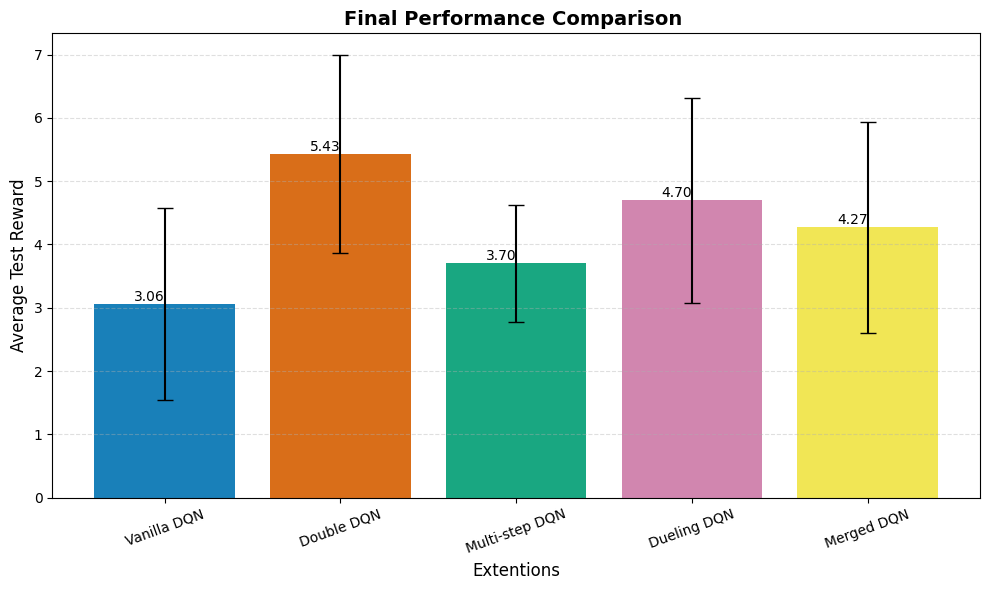

In [73]:
def plot_final_test_performance_bar(test_results,title,save_path):
    """
    Final bar plot
    """

    agents = list(test_results.keys())
    means = [np.mean(test_results[a]) for a in agents]
    stds = [np.std(test_results[a]) for a in agents]

    colors = [
        "#0072B2",  # Vanilla
        "#D55E00",  # Double
        "#009E73",  # Multi-step
        "#CC79A7",  # Dueling
        "#F0E442",  # Merged
    ]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        agents,
        means,
        yerr=stds,
        capsize=6,
        color=colors[:len(agents)],
        alpha=0.9
    )

    plt.ylabel("Average Test Reward", fontsize=12)
    plt.xlabel("Extentions", fontsize=12)
    plt.title(title, fontsize=14, fontweight="bold")

    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.xticks(rotation=20)

    # Annotate mean values
    for bar, mean in zip(bars, means):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{mean:.2f}",
            ha="right",
            va="bottom",
            fontsize=10
        )

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

    

plot_final_test_performance_bar(
    test_results,
    title="Final Performance Comparison ",
    save_path="results/dqn_test_performance_bar_chart.png"
)



In [37]:
from IPython.display import Image as IImage
from PIL import Image

def save_rgb_animation(rgb_arrays, filename, duration=100):
    """Save an animated GIF from a list of RGB arrays."""
    frames = []
    
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array * 255).astype(np.uint8)
        rgb_array = rgb_array.repeat(48, axis=0).repeat(48, axis=1)
        img = Image.fromarray(rgb_array)
        frames.append(img)
    
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]
    
    for _ in range(max_steps):
        action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0))
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())
        
        if terminated or truncated:
            break
    
    return imgs

# Generate videos 
# vanilla DQN
vanilla_policy = make_epsilon_greedy_policy(vanilla_agent.q, num_actions=env.action_space.n)
vanilla_imgs = rendered_rollout(vanilla_policy, env)
save_rgb_animation(vanilla_imgs, "results/Fvanilla_dqn_trained.gif")

# double DQN
double_policy = make_epsilon_greedy_policy(double_agent.q, num_actions=env.action_space.n)
double_imgs = rendered_rollout(double_policy, env)
save_rgb_animation(double_imgs, "results/Fdouble_dqn_trained.gif")

# multistep DQN
multistep_policy = make_epsilon_greedy_policy(multistep_agent.q, num_actions=env.action_space.n)
multistep_imgs = rendered_rollout(multistep_policy, env)
save_rgb_animation(multistep_imgs, "results/Fmultistep_dqn_trained.gif")

# dueling DQN
dueling_policy = make_epsilon_greedy_policy(dueling_agent.q, num_actions=env.action_space.n)
dueling_imgs = rendered_rollout(dueling_policy, env)
save_rgb_animation(dueling_imgs, "results/Fdueling_dqn_trained.gif")


# All three extentions merged
merged_policy = make_epsilon_greedy_policy(merged_agent.q, num_actions=env.action_space.n)
merged_imgs = rendered_rollout(merged_policy, env)
save_rgb_animation(merged_imgs, "results/Fmerged_dqn_trained.gif")




# I think we should remove the following code  , if not that imp 

**SOME DRAFTS IDK**

In [ ]:
# Check what the agent learned
print("=== Double DQN Agent Analysis ===\n")

# Check final epsilon value
print(f"Final epsilon reached: {linear_epsilon_decay(EPS_START, EPS_END, SCHEDULE_DURATION, SCHEDULE_DURATION):.4f}")

# Analyze Q-values
with torch.no_grad():
    # Sample some states from replay buffer (unpack the result - first element are the states)
    if len(double_agent.buffer) > 0:
        sample_states, _, _, _, _, _ = double_agent.buffer.sample(min(32, len(double_agent.buffer)))
        q_values = double_agent.q(sample_states.float())
        
        print(f"\nQ-value statistics from sampled states:")
        print(f"  Mean Q-value: {q_values.mean().item():.4f}")
        print(f"  Std Q-value: {q_values.std().item():.4f}")
        print(f"  Max Q-value: {q_values.max().item():.4f}")
        print(f"  Min Q-value: {q_values.min().item():.4f}")
        print(f"  Q-value range per state (avg): {(q_values.max(dim=1)[0] - q_values.min(dim=1)[0]).mean().item():.4f}")

# Check action distribution in replay buffer
if len(double_agent.buffer) > 0:
    _, actions, _, _, _, _ = double_agent.buffer.sample(min(1000, len(double_agent.buffer)))
    actions = actions.long()  # ensure integer dtype for bincount
    action_counts = torch.bincount(actions, minlength=env.action_space.n)
    print(f"\nAction distribution in replay buffer:")
    for i, count in enumerate(action_counts):
        print(f"  Action {i}: {count.item()} ({count.item()/len(actions)*100:.1f}%)")

# Compare with vanilla DQN
print("\n=== Vanilla DQN Agent Analysis ===\n")
with torch.no_grad():
    if len(vanilla_agent.buffer) > 0:
        sample_states, _, _, _, _, _ = vanilla_agent.buffer.sample(min(32, len(vanilla_agent.buffer)))
        q_values = vanilla_agent.q(sample_states.float())
        
        print(f"Q-value statistics from sampled states:")
        print(f"  Mean Q-value: {q_values.mean().item():.4f}")
        print(f"  Std Q-value: {q_values.std().item():.4f}")
        print(f"  Max Q-value: {q_values.max().item():.4f}")
        print(f"  Min Q-value: {q_values.min().item():.4f}")
        print(f"  Q-value range per state (avg): {(q_values.max(dim=1)[0] - q_values.min(dim=1)[0]).mean().item():.4f}")

# Check action distribution in replay buffer
if len(vanilla_agent.buffer) > 0:
    _, actions, _, _, _, _ = vanilla_agent.buffer.sample(min(1000, len(vanilla_agent.buffer)))
    actions = actions.long()  # ensure integer dtype for bincount
    action_counts = torch.bincount(actions, minlength=env.action_space.n)
    print(f"\nAction distribution in replay buffer:")
    for i, count in enumerate(action_counts):
        print(f"  Action {i}: {count.item()} ({count.item()/len(actions)*100:.1f}%)")